In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.datasets import load_boston

from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel


In [17]:
# boston = load_boston()

# boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)  # 説明変数
# boston_df['PRICE'] = boston.target  # 目的変数を追加
# boston_df.head(3)

data = pd.read_excel("../data/230616_AI用qPCRデータ.xlsx", index_col=0)
data = data.T
data.head()

gene,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
glk,0.000004,7.676792e-06,7.670370e-06,3.852682e-06,7.733864e-06,1.548748e-05,7.666203e-06,3.809448e-06,3.838373e-06,3.796956e-06,...,0.000004,0.000016,0.000063,0.000016,0.000015,0.000122,0.000002,0.000016,0.000008,0.000061
agp,0.000030,3.062644e-05,7.608227e-06,1.513944e-05,4.768491e-07,7.673560e-06,3.074730e-05,3.765629e-06,7.703699e-06,3.745235e-06,...,0.000004,0.000031,0.000249,0.000062,0.000061,0.000241,0.000002,0.000015,0.000008,0.000060
yihX,0.000004,1.550379e-05,1.555514e-05,1.535580e-05,3.109628e-05,1.548903e-05,1.562489e-05,3.881204e-06,7.861457e-06,7.779159e-06,...,0.000002,0.000016,0.000126,0.000032,0.000031,0.000249,0.000004,0.000008,0.000016,0.000062
pgm,0.000015,2.940716e-08,1.396326e-08,1.225795e-07,6.105349e-08,1.244073e-07,7.638838e-09,6.108380e-08,3.052287e-08,1.215061e-07,...,0.000004,0.000031,0.000125,0.000031,0.000031,0.000247,0.000004,0.000008,0.000004,0.000031
ptsG,0.000015,1.547576e-05,3.149074e-05,1.549828e-05,3.140872e-05,3.179367e-05,3.156063e-05,3.874765e-06,1.597435e-05,7.794601e-06,...,0.000008,0.000063,0.000128,0.000064,0.000063,0.000500,0.000016,0.000016,0.000032,0.000126


In [11]:
SM = from_pandas(data)

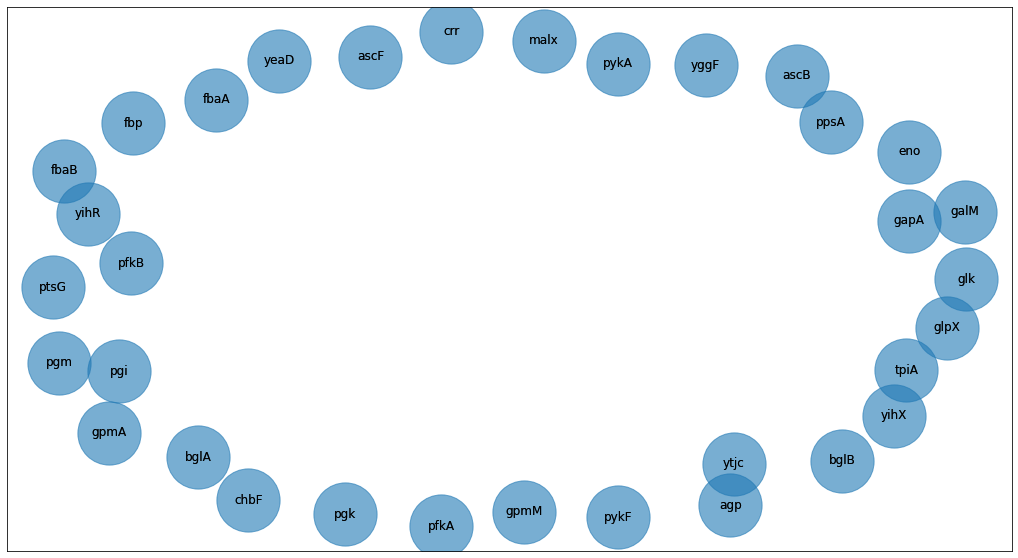

In [9]:
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(SM, k=60)

edge_width = [d['weight']*0.3 for (u, v, d) in SM.edges(data=True)]
nx.draw_networkx_labels(SM, pos
                        # , font_size=16, font_family="Yu Gothic", font_weight="bold"
                        )
nx.draw_networkx(SM,
                 pos,
                 node_size=4000,
                 arrowsize=20,
                 alpha=0.6,
                 edge_color='b',
                 width=edge_width)